## Introduction



In this EDA I use sqlite and pandas to perform EDA on the Mental Health in Tech Database from Kaggle and practice applying statistical inference procedures. I look at survey data from 2014 to 2020 and create visualitions to see the distribution of survey answers for the most popular questions. Towards the end of the analysis I pose an interesting question about the data and we find a result.

## Investigation of Data Source

This database is downloaded from https://www.kaggle.com/anth7310/mental-health-in-the-tech-industry. In the description of this Kaggle database, we're told the following:
- The data is from Open Source Mental Illness (OMSI) using survey data from 2014 to 2019.
- The data has been modified by grouping similar questions together.
- Values in the answers table were changed to be more consistent (i.e. the value of 1 may have also appeared as 1.0) These have been formalised to be integers.
- Spelling errors were fixed.

Before we begin exploring the data, I took a look at the website where the data was collected https://osmihelp.org/research. Here it lists one survey conducted each year, ranging from 2014 to 2020, as well as the option to partake in the 2021 survey. All these surveys are covering the same topic, 'Attitudes Towards Mental Health in the Tech Workplace'. 

The first and largest of the surveys (2014) has 2 video links that used this data:
- Mental Health in the Tech Industry | Ed Finkler | Talks at Google: https://www.youtube.com/watch?v=NHulgcO_16U&list=PL1MEC8mwrpaIdzYKRidvNB5eYSwWrqFZ3
- Supporting Mental Health in the Workplace: Creating a Culture of Support: https://www.youtube.com/watch?v=-RCScR9xDQw&list=PL1MEC8mwrpaKCW8piX6mntf6-620Efncf

I watched through both of these videos to get a better perspective of the topic surrounding the data before digging into it.

When you go to take a survey, it states 'All responses are anonymous, and no identifying information will be collected or stored.'. However, we see that the table with answers stores the user ID for each answer, which allows for data re-identification. So we cannot work with these user ids.

The OSMI website also has the dataset available for the 2020 survey, so I'll be adding it to the analysis.

In [1]:
%load_ext lab_black

## Looking at the Data

In [2]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [3]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_colwidth", None)
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize": (10, 10)})

The database **mental_health** contains the following datasets:
- Answer - (PRIMARY/FOREIGN KEY SurveyID, PRIMARY KEY UserID, PRIMARY/FOREIGN KEY QuestionID, TEXT AnswerText)
- Question - (PRIMARY KEY QuestionID, TEXT QuestionText)
- Survey - (PRIMARY KEY INT SurveyID, TEXT Description)

I need to load the database with SQLite

In [4]:
conn = sql.connect("data/mental_health.sqlite")

In [5]:
pd.read_sql("SELECT * FROM Answer LIMIT 5", conn)

,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


In [6]:
pd.read_sql("SELECT * FROM Question LIMIT 5", conn)

,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state or territory do you live in?",4
4,Are you self-employed?,5


In [7]:
pd.read_sql("SELECT * FROM Survey", conn)

,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


I'm going to join these 2 tables together

In [8]:
mental_health = pd.read_sql(
    f"""
       SELECT surveyID survey_id, questiontext question, AnswerText answer
       FROM Answer
       INNER JOIN Question
       ON Answer.QuestionID = Question.questionid
       """,
    conn,
)
mental_health.head()
all_questions = mental_health["question"].unique()
len(all_questions)

105

Since there's 105 questions, we'll only look at the ones that were answered most

In [9]:
num_of_answers = mental_health["question"].value_counts()
questions = num_of_answers[
    num_of_answers.values == num_of_answers.values.max()
].index.to_list()
questions

['Have you ever sought treatment for a mental health disorder from a mental health professional?',
 'Does your employer provide mental health benefits as part of healthcare coverage?',
 'If you live in the United States, which state or territory do you live in?',
 'How many employees does your company or organization have?',
 'What is your gender?',
 'What country do you live in?',
 'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
 'What is your age?',
 'Is your employer primarily a tech company/organization?',
 'Do you have a family history of mental illness?',
 'Would you bring up a mental health issue with a potential employer in an interview?',
 'Are you self-employed?']

We'll check for NA values but no need to check duplicates as it's likely the survey has a lot

In [10]:
mental_health.isna().sum()

survey_id    0
question     0
answer       0
dtype: int64

The survey could still be using a different value for NA, so we need to check what the most common answers are because if there was a different NA value being used, there's a good chance it will be one of the most common answers.

In [11]:
mental_health["answer"].value_counts().index.to_list()[:5]

['-1', 'No', 'Yes', '1', '0']

'-1' is the most used response so it's probably used as a null substitute. We'll remove all rows with this value.

In [12]:
rows_before = len(mental_health)
mental_health = mental_health[mental_health["answer"] != "-1"]
rows_after = len(mental_health)
print(f"Rows before: {rows_before} \nRows after: {rows_after}")

Rows before: 236898 
Rows after: 180300


Number of questions

In [13]:
mental_health["question"].nunique()

104

## Exploring the Most Answered Questions

In [14]:
def get_answers(question):
    return (
        mental_health[mental_health["question"] == question]
        .groupby("answer")
        .size()
        .sort_values(ascending=False)
    )


def get_answers_2020(question):
    return (
        survey_2020[survey_2020.index == question]
        .T.groupby(question)
        .size()
        .sort_values(ascending=False)
    )


def plot_barchart(title, data):
    sns.barplot(x=data.index, y=data.values)
    plt.title(title)
    plt.xlabel("Answer")
    plt.ylabel("Count")
    return plt.show()

In [15]:
gender = get_answers("What is your gender?")
gender

answer
Male                                              2830
Female                                             914
male                                               212
female                                             110
Nonbinary                                            8
non-binary                                           6
Agender                                              4
Genderqueer                                          4
None                                                 3
Non-binary                                           3
Genderfluid                                          3
Trans woman                                          2
Non binary                                           2
agender                                              2
Male-ish                                             2
Other                                                2
Trans man                                            2
Female (trans)                                       2
Enb

We'll need to group most of these values. I think it's best to group Male, Female then Other, because most of the others have only 1 value.

In [16]:
gender["Male"] += gender["male"]
gender["Female"] += gender["female"]
gender["Other"] = sum(gender[4:])
gender = gender[["Male", "Female", "Other"]]
gender.head()

answer
Male      3042
Female    1024
Other      128
dtype: int64

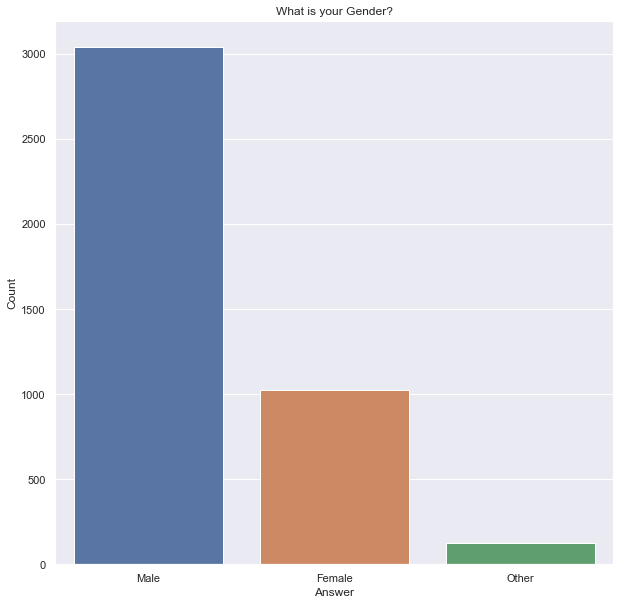

In [17]:
plot_barchart("What is your Gender?", gender)

In [18]:
male_percentage = round((gender["Male"] / gender.sum()) * 100, 2)
print(f"Percentage of Males: {male_percentage}%")

Percentage of Males: 72.53%


It looks like the majority of the survey participants were Male, we should keep this in mind throughout the rest of the analysis.

In [19]:
age = get_answers("What is your age?")
age.index = age.index.astype(int)
age.sort_index(inplace=True)
age

answer
-29       1
 0        1
 3        1
 5        1
 8        1
 11       1
 15       1
 17       1
 18       9
 19      20
 20      17
 21      39
 22      74
 23     107
 24     128
 25     147
 26     194
 27     197
 28     220
 29     229
 30     250
 31     223
 32     227
 33     201
 34     202
 35     201
 36     147
 37     184
 38     160
 39     137
 40     122
 41      88
 42     100
 43      82
 44      68
 45      74
 46      58
 47      38
 48      29
 49      36
 50      30
 51      22
 52      17
 53      15
 54      17
 55      22
 56      13
 57      14
 58       5
 59       6
 60       5
 61       7
 62       3
 63       5
 64       3
 65       3
 66       2
 67       2
 70       1
 72       1
 74       1
 99       1
 323      1
 329      1
dtype: int64

We'll filter out values that are less than 10 or more than 80, then group ages in 10s

In [20]:
age = age[(age.index >= 10) & (age.index <= 80)]

In [21]:
bins = [10, 20, 30, 40, 50, 60, 70, 80]
labels = ["10s", "20s", "30s", "40s", "50s", "60s", "70s"]

age_grouped = pd.cut(age.index, bins=bins, labels=labels,)

In [22]:
age = age.groupby(age_grouped).sum()

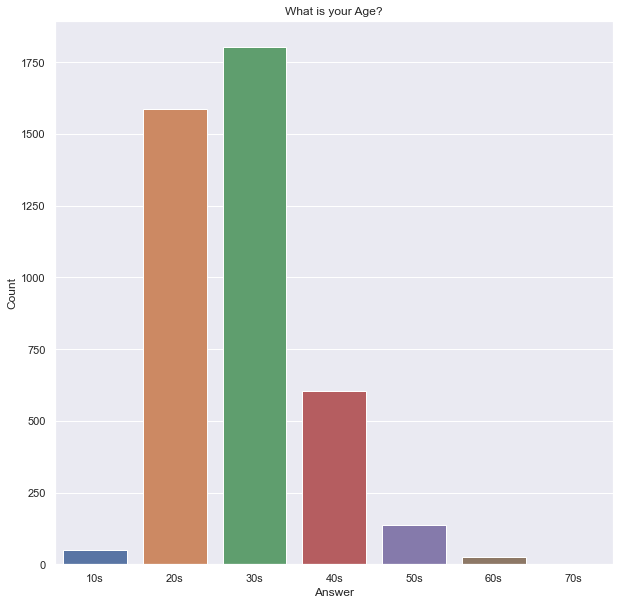

In [23]:
plot_barchart("What is your Age?", age)

Most people lie between 20s and 50s, which is expected as this is the typical age range of the working class.

In [24]:
sought_treatment = get_answers(
    "Have you ever sought treatment for a mental health disorder from a mental health professional?"
)
sought_treatment

answer
1    2412
0    1806
dtype: int64

In [25]:
sought_treatment = sought_treatment.rename(index={"1": "Yes", "0": "No"})

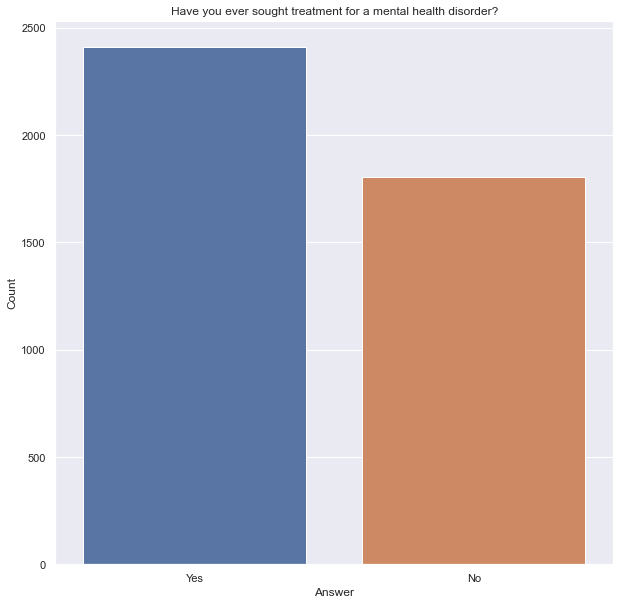

In [26]:
plot_barchart(
    "Have you ever sought treatment for a mental health disorder?", sought_treatment
)

This is interesting to see as this survey wasn't directed to people with mental health disorders and still the majority of participants are affected by it.

In [27]:
anonymity_protected = get_answers(
    "Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?"
)
anonymity_protected

answer
I don't know    1546
Yes             1135
Don't know       820
No               213
dtype: int64

In [28]:
anonymity_protected["Don't know"] += anonymity_protected["I don't know"]
anonymity_protected.drop("I don't know", axis=0, inplace=True)
anonymity_protected = anonymity_protected.reindex(["Yes", "No", "Don't know"])

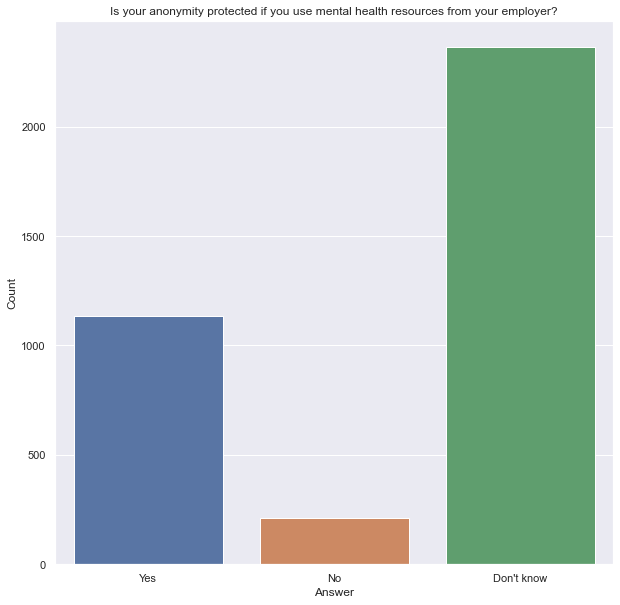

In [29]:
plot_barchart(
    "Is your anonymity protected if you use mental health resources from your employer?",
    anonymity_protected,
)

This is a bad sign, there could be a lot of people who don't seek these resources in fear of their anonymity not being protected

In [30]:
tech_company = get_answers("Is your employer primarily a tech company/organization?")
tech_company

answer
1    2888
0     826
dtype: int64

In [31]:
interview = get_answers(
    "Would you bring up a mental health issue with a potential employer in an interview?"
)
interview

answer
No       2951
Maybe    1036
Yes       231
dtype: int64

In [32]:
interview = interview.reindex(["Yes", "No", "Maybe"])

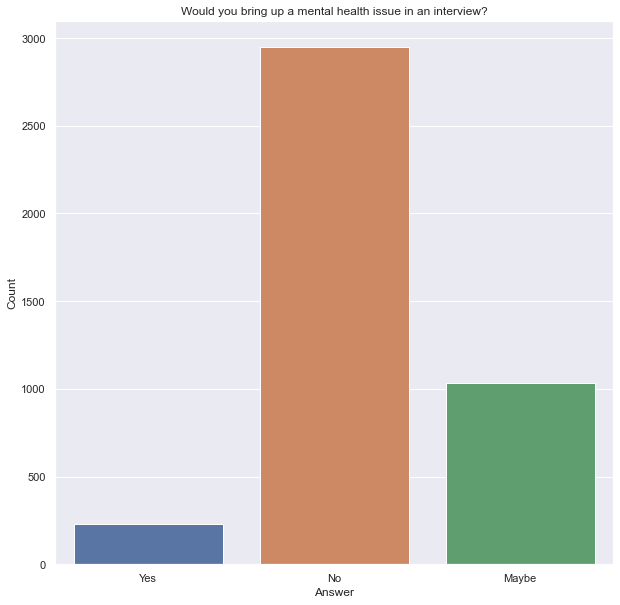

In [33]:
plot_barchart(
    "Would you bring up a mental health issue in an interview?", interview,
)

Only a few participants would bring up mental health in an interview. People may feel insecure about their condition to talk about it, or think that it will have a negative impact on their interview.

In [34]:
provides_benefits = get_answers(
    "Does your employer provide mental health benefits as part of healthcare coverage?"
)
provides_benefits

answer
Yes                               1744
No                                 756
I don't know                       658
Don't know                         408
Not eligible for coverage / NA     148
dtype: int64

In [35]:
provides_benefits["Don't know"] += provides_benefits["I don't know"]
provides_benefits = provides_benefits.rename(
    index={"Not eligible for coverage / NA": "Not eligible"}
)
provides_benefits.drop("I don't know", axis=0, inplace=True)

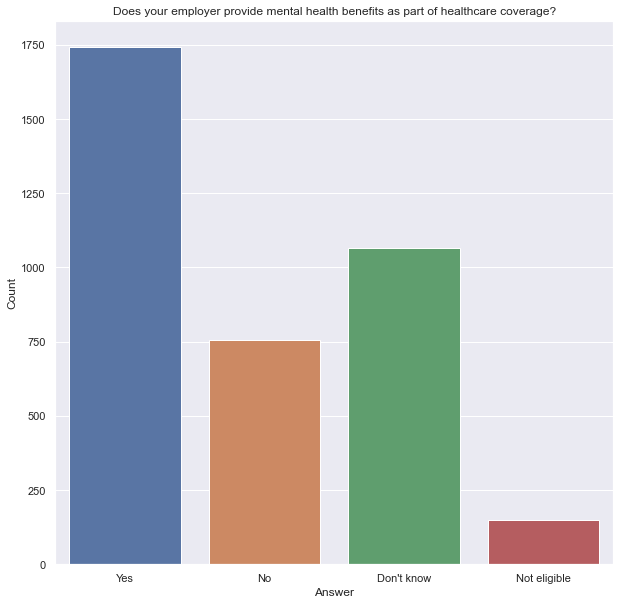

In [36]:
plot_barchart(
    "Does your employer provide mental health benefits as part of healthcare coverage?",
    provides_benefits,
)

A lot of people appear to be aware of mental health benefits but the amount that don't know shows that this should be exposed more in the companies

In [37]:
country = get_answers("What country do you live in?")
country

answer
United States of America    1853
United States                751
United Kingdom               482
Canada                       199
Germany                      136
Netherlands                   98
Australia                     73
Ireland                       51
France                        51
India                         50
Brazil                        37
Sweden                        29
Switzerland                   28
Spain                         26
New Zealand                   24
Portugal                      23
Poland                        21
Italy                         19
Belgium                       17
Russia                        16
South Africa                  16
Finland                       13
Bulgaria                      13
Mexico                        12
Norway                        12
Austria                       10
Romania                        9
Israel                         9
Japan                          9
Denmark                        9
Gre

In [38]:
country["United States"] += country["United States of America"]
country.drop(index={"United States of America"}, inplace=True)
country.rename(index={"United States": "US", "United Kingdom": "UK"}, inplace=True)

In [39]:
other = country[10:].sum()

In [40]:
country = country[:10]
country["Other"] = other

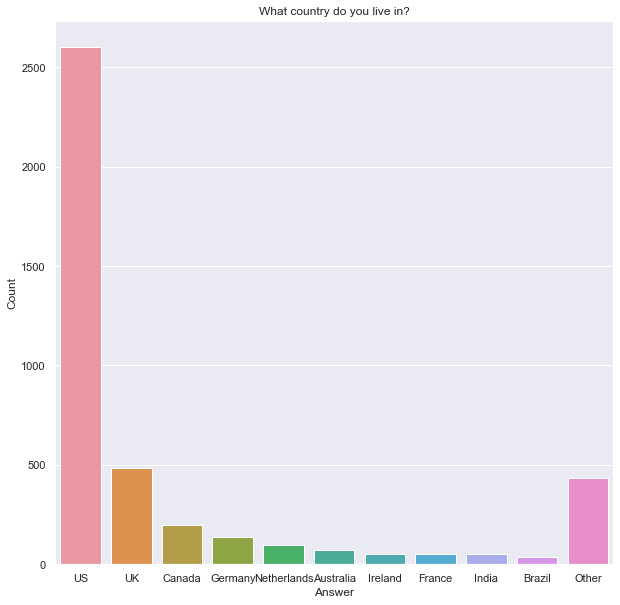

In [41]:
plot_barchart("What country do you live in?", country)

In [42]:
print(f"US: {country[:1].sum()} \nOther: {country[1:].sum()}")

US: 2604 
Other: 1612


Even with all other countries combined, most of the participants are living in the US

In [43]:
employees = get_answers("How many employees does your company or organization have?")

In [44]:
employees = employees.rename(index={"More than 1000": ">1000"})
employees = employees.reindex(["1-5", "6-25", "26-100", "100-500", "500-1000", ">1000"])

We find the category that the median lies in

In [45]:
employees

answer
1-5         254
6-25        689
26-100      824
100-500     788
500-1000    247
>1000       912
dtype: int64

In [46]:
employees.sum() / 2

1857.0

This means the median lies in 100-500, so from this we can see that a lot of the participants work at large companies

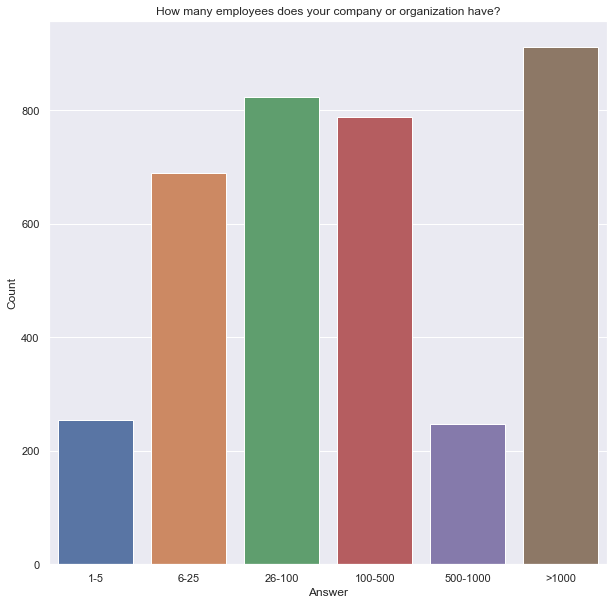

In [47]:
plot_barchart("How many employees does your company or organization have?", employees)

## In 2020, was there a significant change in difficulty to ask for leave for a mental health issue?

This could be interesting due the COVID pandemic and increase in working from home. We'll need to look at the data from the OSMI 2020 survey, which isn't included in the previous mental_health database

In [48]:
survey_2020 = pd.read_csv("data/survey_2020.csv")

In [49]:
survey_2020.head()

,#,*Are you self-employed?*,How many employees does your company or organization have?,Is your employer primarily a tech company/organization?,Is your primary role within your company related to tech/IT?,Does your employer provide mental health benefits as part of healthcare coverage?,Do you know the options for mental health care available under your employer-provided health coverage?,"Has your employer ever formally discussed mental health (for example, as part of a wellness campaign or other official communication)?",Does your employer offer resources to learn more about mental health disorders and options for seeking help?,Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?,...,"If there is anything else you would like to tell us that has not been covered by the survey questions, please use this space to do so.",Would you be willing to talk to one of us more extensively about your experiences with mental health issues in the tech industry? (Note that all interview responses would be used _anonymously_ and only with your permission.),What is your age?,What is your gender?,What country do you *live* in?,What US state or territory do you *live* in?,What is your race?,Other.3,What country do you *work* in?,What US state or territory do you *work* in?
0,zwrffw6ykfo82ft1twvzwrffw6c6wsfv,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,45,Male,United States of America,Connecticut,White,NaN,United States of America,Connecticut
1,zhdmhaa8r0125c4zmoi7qzhdmtjrakhm,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,24,female,Russia,NaN,NaN,NaN,Russia,NaN
2,x4itwa9hnlw7qke4y5xibx4itwa9yzl5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,mental health should be a law by government.,1,46,Male,India,NaN,NaN,NaN,India,NaN
3,x3v3oimu5pn0043n8x3v3oizaybhwwto,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,25,Female,Canada,NaN,NaN,NaN,Canada,NaN
4,uyp6re7bhnyx6gez09uyp6re72z0e4e4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,no,1,25,F,Canada,NaN,NaN,NaN,Canada,NaN


It's in a completely different format that the one we were working with before, so we'll have to change it.

In [50]:
survey_2020 = survey_2020.T.reset_index()
survey_2020.rename(columns={"index": "question"}, inplace=True)
survey_2020.set_index("question", inplace=True)
survey_2020.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
question,,,,,,,,,,,,,,,,,,,,,
#,zwrffw6ykfo82ft1twvzwrffw6c6wsfv,zhdmhaa8r0125c4zmoi7qzhdmtjrakhm,x4itwa9hnlw7qke4y5xibx4itwa9yzl5,x3v3oimu5pn0043n8x3v3oizaybhwwto,uyp6re7bhnyx6gez09uyp6re72z0e4e4,u0nbmruq4qexmkk8zvqsu0nbmrh6he0e,t4ck9zq73fzi90rtcfgzu0ot4ck9zzub,sics80avlof5gljw4fqrl7sics805x6i,rd0ztpn1g47k7bhehrd0ztt4hk3qv0kp,qxhj26vbyd7zlgbi1xqxhj26nalmk3sa,...,1pn8gueuutq0i3gx1pn8gw3ke9pa00pp,1b1l167vv3dkjlnpgsq1b1l1h2jhn6vf,18pbytb7yblon6nnjh8o18pbytcwj66m,15ymmnmxl7jf46oql15ymmltwey4xn1c,12bjqz066nmgymnctn12bjq90slxyeji,0wrer2048ezmupzx43w90wrer20yc1kw,0uwk39tqe1301annaj00uwk36l3gcj5c,0one9qodhxn97la0onyoa7723zcfjjcq,0gwigf5te8921teu30gwigf6l4r66gc9,0ezwd0r69klk35revk0ezwocuudi4f4e
*Are you self-employed?*,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
How many employees does your company or organization have?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,More than 1000,More than 1000,500-1000,26-100,More than 1000,More than 1000,26-100,100-500,500-1000,500-1000
Is your employer primarily a tech company/organization?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
Is your primary role within your company related to tech/IT?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [51]:
survey_2020 = survey_2020[survey_2020.index.isin(all_questions)]
survey_2020.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
question,,,,,,,,,,,,,,,,,,,,,
How many employees does your company or organization have?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,More than 1000,More than 1000,500-1000,26-100,More than 1000,More than 1000,26-100,100-500,500-1000,500-1000
Is your employer primarily a tech company/organization?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
Is your primary role within your company related to tech/IT?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Does your employer provide mental health benefits as part of healthcare coverage?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,I don't know,Yes,I don't know,Yes,I don't know,No,Yes,I don't know,Yes,Not eligible for coverage / NA
Do you know the options for mental health care available under your employer-provided health coverage?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Yes,No,Yes,No,No,Yes,No,No,NaN


In [52]:
gender_2020 = get_answers_2020("What is your gender?")

In [53]:
male = gender_2020[
    ["M", "MAle", "cisgender male", "m", "mail", "male", "mostly male"]
].sum()
female = gender_2020[["F", "FEMALE", "f", "female, she/her", "female"]].sum()

In [54]:
gender_2020 = gender_2020[["Male", "Female"]]

In [55]:
gender_2020["Male"] += male
gender_2020["Female"] += female

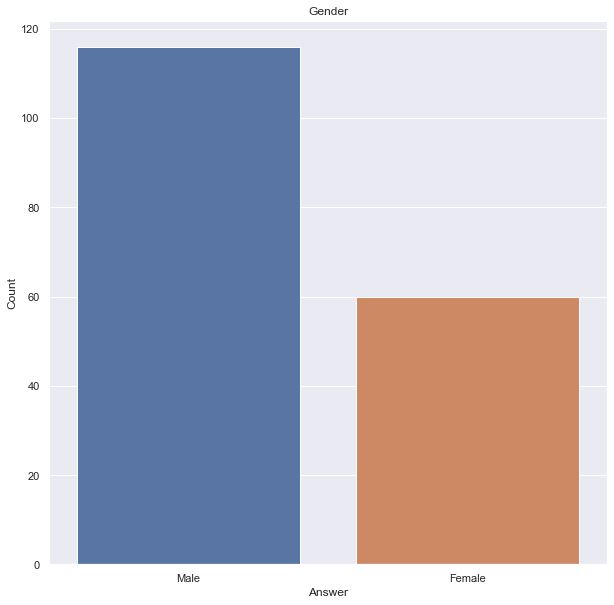

In [56]:
plot_barchart("Gender", gender_2020)

In [57]:
male_percentage = round((gender_2020["Male"] / gender_2020.sum()) * 100, 2)
print(f"Percentage of Males: {male_percentage}%")

Percentage of Males: 65.91%


The percentage of Males to Females is similar to the other dataset

In [58]:
(survey_2020.index == "Do you work remotely?").any()

False

It looks like there's no question in the 2020 survey table that asks if they work remotely. But since we know that most of the participants in the survey are from the US, I found what percentage of people were working remotely by the end of 2020. https://resources.owllabs.com/state-of-remote-work/2020 and the result is about 69% working from home.

Number of remote workers in the 2014-2019 surveys:

In [59]:
remote = get_answers("Do you work remotely?")
remote

answer
Sometimes    757
Always       343
Never        333
dtype: int64

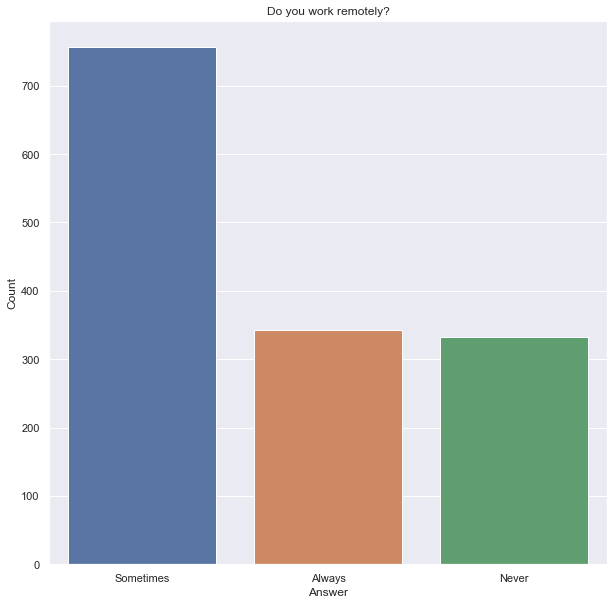

In [60]:
plot_barchart("Do you work remotely?", remote)

In [61]:
remote_percent = round((remote["Always"] / remote.sum()) * 100, 2)
print(f"Percentage working remotely between 2014-2019: {remote_percent}%")

Percentage working remotely between 2014-2019: 23.94%


So the percentage of remote workers at the end of 2020 is nearly 3 times the amount from the previous surveys

In [62]:
leave = get_answers(
    "If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?"
)
leave_percent = leave / leave.sum()
leave_percent["Easy"] = leave_percent[["Somewhat easy", "Very easy"]].sum()
leave_percent["Difficult"] = leave_percent[
    ["Somewhat difficult", "Very difficult"]
].sum()
leave_percent["I don't know"] += leave_percent["Neither easy nor difficult"]
leave_percent = leave_percent[["Easy", "Difficult", "I don't know"]]
leave_percent

answer
Easy            0.465770
Difficult       0.193969
I don't know    0.294621
dtype: float64

In [63]:
leave_2020 = get_answers_2020(
    "If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?"
)
leave_2020_percent = leave_2020 / leave_2020.sum()
leave_2020_percent["Easy"] = leave_2020_percent[["Somewhat easy", "Very easy"]].sum()
leave_2020_percent["Difficult"] += leave_2020_percent["Somewhat difficult"]
leave_2020_percent["I don't know"] += leave_2020_percent["Neither easy nor difficult"]
leave_2020_percent = leave_2020_percent[["Easy", "Difficult", "I don't know"]]
leave_2020_percent

If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?
Easy            0.477419
Difficult       0.277419
I don't know    0.245161
dtype: float64

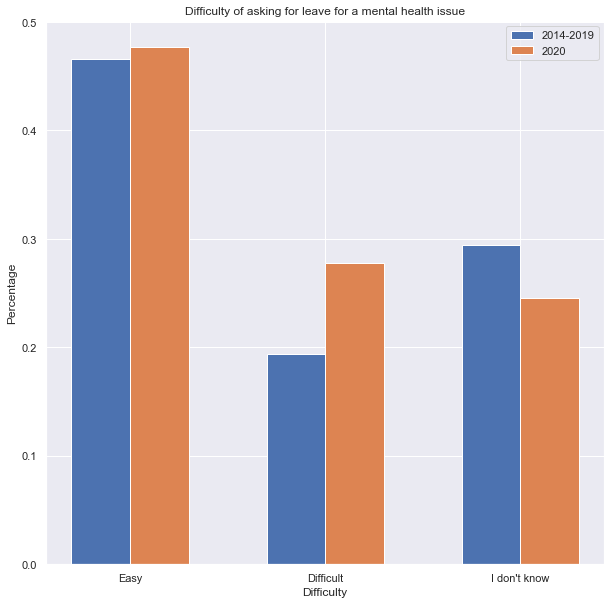

In [67]:
leave_bar = leave_percent.values
leave_2020_bar = leave_2020_percent.values

x = np.arange(3)
width = 0.3

plt.bar(x, leave_bar, width, label="2014-2019")
plt.bar(x + width, leave_2020_bar, width, label="2020")

plt.xlabel("Difficulty")
plt.ylabel("Percentage")
plt.title("Difficulty of asking for leave for a mental health issue")

plt.xticks(np.arange(3) + 0.15, ("Easy", "Difficult", "I don't know"))

plt.legend(loc="best")
plt.show()

So is there an significant change in difficulty to ask for leave in 2020?

In [ ]:
leave_percent = leave_percent["Difficult"] * 100
leave_2020_percent = leave_2020_percent["Difficult"] * 100
difference = round(leave_2020_percent - leave_percent, 2)
print(
    f"""
    Sample size of 2014-2019: {sum(leave)}, percentage that find asking for leave difficult: {round(leave_percent, 2)}%
    Sample size of 2020: {sum(leave_2020)}, percentage that find asking for leave difficult: {round(leave_2020_percent, 2)}%
    Difference: {difference}%
    """
)

## Conclusion

The overall trend we're seeing here is that the whole idea of mental health needs pushed to be a normal topic of conversation with your employer or coworkers, just like any any physical issue would be. This would help those with mental health issues feel more comfortable in the workplace, especially now that companies are becoming more disconnected due to the increase in remote working. Because of this huge change, I'm expecting the results of the 2020 OSMI survey to be very different.